Dataset: **Neurotech@Rice Datathon Challenge**  

In [1]:
# !pip install mne pyedflib seglearn tsfel tsfresh antropy plotly-resampler tsflex powershap --upgrade

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("/home/xavier/PycharmProjects/sleep-linear/src/")

In [3]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [4]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from plotly_resampler import FigureResampler

## Download the data from Google Drive

# Create dataloader

## Load some data

In [5]:
data_folder = "/home/xavier/PycharmProjects/sleep-linear/data/Neurotech@Rice Datathon Challenge"

os.listdir(data_folder)
training_set = f"{data_folder}/Training [NEW]"
items = [item.split('NEW')[0] for item in os.listdir(training_set)]
items = np.unique(items)
items.sort()
signal_files = []
for item in items:
    if not os.path.exists(f"{training_set}/{item}NEW_X.npy") or not os.path.exists(f"{training_set}/{item}NEW_y.npy"):
        print(f"{item} is missing!")
    else:
        signal_info = (item[1:3], item[5:6], f"{item}NEW_X.npy", f"{item}NEW_y.npy")
        signal_files.append(signal_info)
signal_files = sorted(signal_files, key=lambda x: (x[0], x[1]))
df_files = pd.DataFrame(signal_files, columns=["patient_id", "night_id", "edf_file", "label_file"])
df_files

p10_n2_ is missing!
p11_n1_ is missing!


,patient_id,night_id,edf_file,label_file
0,00,1,p00_n1_NEW_X.npy,p00_n1_NEW_y.npy
1,00,2,p00_n2_NEW_X.npy,p00_n2_NEW_y.npy
2,01,1,p01_n1_NEW_X.npy,p01_n1_NEW_y.npy
3,02,1,p02_n1_NEW_X.npy,p02_n1_NEW_y.npy
4,02,2,p02_n2_NEW_X.npy,p02_n2_NEW_y.npy
5,03,1,p03_n1_NEW_X.npy,p03_n1_NEW_y.npy
6,03,2,p03_n2_NEW_X.npy,p03_n2_NEW_y.npy
7,04,1,p04_n1_NEW_X.npy,p04_n1_NEW_y.npy
8,04,2,p04_n2_NEW_X.npy,p04_n2_NEW_y.npy
9,05,1,p05_n1_NEW_X.npy,p05_n1_NEW_y.npy


=> In total 41 files (41 EDF files - 41 hypnogram files) 

In [6]:
df_files.patient_id.nunique()

23

In [7]:
df_files.edf_file.nunique()

41

=> edf file can be used as recordingid   
=> patient id can be used as patient id 

In [8]:
common_signals = [
    'EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal',  # All have the same sampling rate (100 Hz)
    'Resp oro-nasal',
    'EMG submental',  # Also 100 Hz
    'Temp rectal'
]

def load_edf(file_path:str):
    X = np.load(file_path)
    X = np.hstack(X)
    index_X = pd.date_range(start=0, periods=X.shape[1], freq=pd.Timedelta(1 / 100, unit="s"))
    data = []
    for i in range(X.shape[0]):
        data.append(pd.Series(X[i, :], index=index_X, name=common_signals[i]))
    return data

def load_label(file_path: str):
    y = np.load(file_path)
    index_y = pd.date_range(start=0, periods=y.shape[0], freq=pd.Timedelta(30, unit="s"))
    annotations = pd.Series(y, index=index_y)
    return annotations


def labels_to_30s(labels):
    index = labels.index
    values = [cats[int(val)] for val in annotations.values]
    return pd.DataFrame({"label": values}, index=index)

idx = 0
data = load_edf(f"{training_set}/{df_files.iloc[idx].edf_file}")
annotations = load_label(f"{training_set}/{df_files.iloc[idx].label_file}")


In [9]:
# Used for plotting
cats = [
    "Sleep stage ?",
    "Sleep stage W",
    "Sleep stage 1",
    "Sleep stage 2",
    "Sleep stage 3",
    "Sleep stage 4",
    "Sleep stage R",
]


# EDA + pipeline (for 1 patient)

In [10]:
idxs = [s.name for s in data]

fig = FigureResampler(
    make_subplots(
        rows=len(idxs) + 1,
        cols=1,
        shared_xaxes=True,
        subplot_titles=idxs  + ["Hypnogram"],
        vertical_spacing=0.05,
    ),
    default_n_shown_samples=3_000,
)

for idx, s in enumerate(data, 1):
    fig.add_trace(
        go.Scattergl(
            x=[], y=[], name=s.name, line_width=1,
        ),
        hf_x=s.index,
        hf_y=s.values,
        row=idx,
        col=1,
    )


y_ticks = pd.Series([cats[int(val)] for val in annotations.values])

fig.add_trace(
    go.Scattergl(
        x=[], y=[], name="Hypnogram", line_width=1.5, line_shape="hv",
    ),
    hf_x=annotations.index,
    hf_y=y_ticks.astype("category"),
    row=len(idxs) + 1,
    col=1,
)

fig.update_layout(height=1300)
fig.update_yaxes(categoryorder="array", categoryarray=cats)
# 
fig.update_layout(
    legend_traceorder="normal",
    template="plotly_white",
    legend=dict(orientation="h", y=1.07, xanchor="right", x=1),
)

fig.show_dash(port=8043)

## Process the signals

In [16]:
## Processing
from scipy.signal import butter, lfilter

from tsflex.processing import SeriesPipeline, SeriesProcessor


def butter_bandpass_filter(sig, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype="band")
    y = lfilter(b, a, sig)
    return y

eeg_bandpass = SeriesProcessor(
    function=butter_bandpass_filter,
    series_names=["EEG Fpz-Cz", "EEG Pz-Oz", "EOG horizontal"],
    lowcut=0.4,
    highcut=30,
    fs=100,
)

emg_bandpass = SeriesProcessor(
    function=butter_bandpass_filter,
    series_names=["EMG submental"],
    lowcut=0.5,
    highcut=10,
    fs=100,
)

process_pipe = SeriesPipeline(
    [
        eeg_bandpass,
        emg_bandpass,
    ]
)

process_pipe

[
	butter_bandpass_filter {'lowcut': 0.4, 'highcut': 30, 'fs': 100} :  ('EEG Fpz-Cz',) ('EEG Pz-Oz',) ('EOG horizontal',)
	butter_bandpass_filter {'lowcut': 0.5, 'highcut': 10, 'fs': 100} :  ('EMG submental',)
]

In [17]:
%%time
data_processed = process_pipe.process(data, return_all_series=True)

CPU times: user 247 ms, sys: 15.3 ms, total: 262 ms
Wall time: 261 ms


In [18]:
for s in data_processed:
    idx = idxs.index(s.name.split("_")[-1]) + 1
    fig.add_trace(
        go.Scatter(x=[], y=[], name=s.name + " processed", line_width=1),
        hf_x=s.index,
        hf_y=s.values,
        row=idx,
        col=1,
    )
    
fig.show_dash(port=8043)

## Extract the features

In [19]:
# Create the collection of tsfresh features to extract

tsfresh_settings = {
    "fft_aggregated": [
        {"aggtype": "centroid"},
        {"aggtype": "variance"},
        {"aggtype": "skew"},
        {"aggtype": "kurtosis"},
    ],
    "fourier_entropy": [
        {"bins": 2},
        {"bins": 3},
        {"bins": 5},
        {"bins": 10},
        {"bins": 30},
        {"bins": 60},
        {"bins": 100},
    ],
    "binned_entropy": [
        {"max_bins": 5},
        {"max_bins": 10},
        {"max_bins": 30},
        {"max_bins": 60},
    ],
}

tsfresh_settings


{'fft_aggregated': [{'aggtype': 'centroid'},
  {'aggtype': 'variance'},
  {'aggtype': 'skew'},
  {'aggtype': 'kurtosis'}],
 'fourier_entropy': [{'bins': 2},
  {'bins': 3},
  {'bins': 5},
  {'bins': 10},
  {'bins': 30},
  {'bins': 60},
  {'bins': 100}],
 'binned_entropy': [{'max_bins': 5},
  {'max_bins': 10},
  {'max_bins': 30},
  {'max_bins': 60}]}

In [20]:
import antropy as ant
import scipy.stats as ss
from yasa import bandpower

import scipy.stats as ss
from tsflex.features import (
    FeatureCollection,
    FuncWrapper,
    MultipleFeatureDescriptors,
    FuncWrapper,
)
from tsflex.features.integrations import tsfresh_settings_wrapper


def wrapped_higuchi_fd(x):
    x = np.array(x, dtype="float64")
    return ant.higuchi_fd(x)


bands = [
    (0.4, 1, "sdelta"),
    (1, 4, "fdelta"),
    (4, 8, "theta"),
    (8, 12, "alpha"),
    (12, 16, "sigma"),
    (16, 30, "beta"),
]
bandpowers_ouputs = [b[2] for b in bands] + ["TotalAbsPow"]


def wrapped_bandpowers(x, sf, bands):
    return bandpower(x, sf=sf, bands=bands).values[0][:-2]


time_funcs = [
    np.std,
    ss.iqr,
    ss.skew,
    ss.kurtosis,
    ant.num_zerocross,
    FuncWrapper(
        ant.hjorth_params, output_names=["horth_mobility", "hjorth_complexity"]
    ),
    wrapped_higuchi_fd,
    ant.petrosian_fd,
    ant.perm_entropy,
] + tsfresh_settings_wrapper(tsfresh_settings)

freq_funcs = [
    FuncWrapper(wrapped_bandpowers, sf=100, bands=bands, output_names=bandpowers_ouputs)
]

time_feats = MultipleFeatureDescriptors(
    time_funcs,
    ["EEG Fpz-Cz", "EEG Pz-Oz", "EOG horizontal", "EMG submental"],
    windows=["30s", "60s", "90s"],
    strides="30s",
)
freq_feats = MultipleFeatureDescriptors(
    freq_funcs,
    ["EEG Fpz-Cz", "EEG Pz-Oz", "EOG horizontal"],
    windows=["30s", "60s", "90s"],
    strides="30s",
)

feature_collection = FeatureCollection([time_feats, freq_feats])
# fc


In [21]:
import logging

from tsflex.features.logger import logger

logger.setLevel(level=logging.ERROR)

from tsflex.processing.logger import logger

logger.setLevel(level=logging.ERROR)


In [22]:
# %%time
feats = feature_collection.calculate(data_processed, return_df=True, show_progress=True)
feats

  0%|          | 0/261 [00:00<?, ?it/s]

,EEG Fpz-Cz__TotalAbsPow__w=1m,EEG Fpz-Cz__TotalAbsPow__w=1m30s,EEG Fpz-Cz__TotalAbsPow__w=30s,EEG Fpz-Cz__alpha__w=1m,EEG Fpz-Cz__alpha__w=1m30s,EEG Fpz-Cz__alpha__w=30s,EEG Fpz-Cz__beta__w=1m,EEG Fpz-Cz__beta__w=1m30s,EEG Fpz-Cz__beta__w=30s,EEG Fpz-Cz__binned_entropy_{'max_bins': 10}__w=1m,...,EOG horizontal__skew__w=30s,EOG horizontal__std__w=1m,EOG horizontal__std__w=1m30s,EOG horizontal__std__w=30s,EOG horizontal__theta__w=1m,EOG horizontal__theta__w=1m30s,EOG horizontal__theta__w=30s,EOG horizontal__wrapped_higuchi_fd__w=1m,EOG horizontal__wrapped_higuchi_fd__w=1m30s,EOG horizontal__wrapped_higuchi_fd__w=30s
1970-01-01 00:00:30,NaN,NaN,0.0,NaN,NaN,0.011966,NaN,NaN,0.01293,NaN,...,0.173134,NaN,NaN,0.000071,NaN,NaN,0.031219,NaN,NaN,1.257986
1970-01-01 00:01:00,0.0,NaN,0.0,0.018171,NaN,0.028862,0.024353,NaN,0.046444,1.667629,...,0.203721,0.000074,NaN,0.000076,0.042809,NaN,0.058202,1.488313,NaN,1.641231
1970-01-01 00:01:30,0.0,0.0,0.0,0.032559,0.0239,0.032287,0.03873,0.027223,0.027552,1.564244,...,-0.279640,0.000071,0.000071,0.000065,0.032964,0.034947,0.025595,1.607514,1.512376,1.563791
1970-01-01 00:02:00,0.0,0.0,0.0,0.056282,0.041142,0.074854,0.03516,0.036783,0.028251,1.431736,...,0.029593,0.000048,0.000059,0.000018,0.064335,0.044394,0.100081,1.660663,1.652097,1.830498
1970-01-01 00:02:30,0.0,0.0,0.0,0.068842,0.063116,0.059463,0.027978,0.034582,0.027121,1.376963,...,-0.439511,0.000016,0.000040,0.000014,0.10672,0.089847,0.111054,1.828444,1.701058,1.827002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970-01-01 22:02:30,0.0,0.0,0.0,0.036642,0.025157,0.030919,0.047035,0.031875,0.034681,1.535747,...,0.067072,0.000056,0.000065,0.000063,0.058822,0.055937,0.045841,1.569018,1.608524,1.519734
1970-01-01 22:03:00,0.0,0.0,0.0,0.035044,0.036785,0.035758,0.040611,0.047695,0.051777,1.621815,...,0.001826,0.000060,0.000057,0.000057,0.045717,0.052746,0.053498,1.611479,1.612943,1.687073
1970-01-01 22:03:30,0.0,0.0,0.0,0.036019,0.031562,0.026256,0.047291,0.039144,0.034697,1.413289,...,-0.010830,0.000067,0.000065,0.000075,0.059213,0.049297,0.064801,1.699283,1.651181,1.711871
1970-01-01 22:04:00,0.0,0.0,0.0,0.037448,0.038002,0.047466,0.042533,0.044301,0.047973,1.410208,...,-0.041717,0.000068,0.000064,0.000060,0.056196,0.055605,0.046247,1.638321,1.653585,1.516722


# Pipeline for all patients

In [23]:
from tqdm.auto import tqdm

df_feats = []
for edf_file, hypnogram_file in tqdm(zip(df_files.edf_file, df_files.label_file)):
    # Load the data, process the data and extract features
    data = load_edf(f"{training_set}/{edf_file}")
    data_processed = process_pipe.process(data)
    df_feat = feature_collection.calculate(
        data_processed, return_df=True, window_idx="begin"
    ).astype("float32")
    # Add the labels (and reduce features to only data for which we have labels)
    annotations = load_label(f"{training_set}/{hypnogram_file}")
    annotations = labels_to_30s(annotations)
    df_feat = df_feat.merge(annotations, left_index=True, right_index=True)
    # Add the file name & folder
    df_feat["edf_file"] = edf_file
    df_feat["patient_id"] = edf_file[1:3]
    # Collect the dataframes
    df_feats += [df_feat]

df_feats = pd.concat(df_feats)
df_feats.rename(columns={"description": "label"}, inplace=True)

0it [00:00, ?it/s]

In [24]:
df_feats.to_parquet("/home/xavier/PycharmProjects/sleep-linear/features/datathon-edf__telemetry_features_ALL__90s.parquet")

## Load data

In [25]:
df_feats = pd.read_parquet("/home/xavier/PycharmProjects/sleep-linear/features/datathon-edf__telemetry_features_ALL__90s.parquet")
df_feats.shape

(112535, 366)

In [26]:
df_feats["label"].value_counts()

Sleep stage W    77110
Sleep stage 2    18464
Sleep stage R     8025
Sleep stage 1     3286
Sleep stage 3     3255
Sleep stage 4     2295
Sleep stage ?      100
Name: label, dtype: int64

In [28]:
df_feats[~df_feats.edf_file.isin(df_files.edf_file.unique())].edf_file.nunique()

0

In [29]:
df_feats.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 112535 entries, 1970-01-01 00:00:00 to 1970-01-01 22:52:00
Columns: 366 entries, EEG Fpz-Cz__TotalAbsPow__w=1m to patient_id
dtypes: float32(363), object(3)
memory usage: 159.3+ MB


In [35]:
eeg_signals = [d.name for d in data_processed if "EEG" in d.name]
bands = ["alpha", "beta", "sdelta", "fdelta", "sigma", "theta"]
for eeg_sig in eeg_signals:
    eeg_bands = [c for c in df_feats.columns if c.startswith(eeg_sig) and c.split("__")[1] in bands]
    windows = sorted(set(b.split("__")[-1] for b in eeg_bands))
    for window in windows:
        # Select the spectral powers
        delta = df_feats["__".join([eeg_sig, "sdelta", window])] + df_feats["__".join([eeg_sig, "fdelta", window])]
        fdelta_theta = df_feats["__".join([eeg_sig, "fdelta", window])] + df_feats["__".join([eeg_sig, "theta", window])]
        alpha = df_feats["__".join([eeg_sig, "alpha", window])]
        beta = df_feats["__".join([eeg_sig, "beta", window])]
        theta = df_feats["__".join([eeg_sig, "theta", window])]
        sigma = df_feats["__".join([eeg_sig, "sigma", window])]
        # Calculate the ratios
        df_feats["__".join([eeg_sig, "fdelta+theta", window])] = fdelta_theta.astype("float32")        

        df_feats["__".join([eeg_sig, "alpha/theta", window])] = (alpha / theta).astype("float32")
        df_feats["__".join([eeg_sig, "delta/beta", window])] = (delta / beta).astype("float32")
        df_feats["__".join([eeg_sig, "delta/sigma", window])] = (delta / sigma).astype("float32")
        df_feats["__".join([eeg_sig, "delta/theta", window])] = (delta / theta).astype("float32")
df_feats.shape

(112535, 396)

In [36]:
skip_cols = ["edf_file", "label", "patient_id"]
feat_cols = [c for c in df_feats.columns if c not in skip_cols]

In [37]:
# Add the 30s features from the minute before and the minute after the epoch (= current sample of 30s) to the epoch
feats_30s = [f for f in df_feats.columns if "w=30s" in f]
feats_60s = [f for f in df_feats.columns if "w=1m_" in f]
feats_90s = [f for f in df_feats.columns if "w=1m30s" in f]
print(len(feats_30s), len(feats_60s), len(feats_90s))
dfs = []
for edf_file in df_feats.edf_file.unique():
    sub_df = df_feats[df_feats.edf_file == edf_file]

    sub_df = sub_df.merge(
        sub_df[feats_90s].shift(1).add_suffix("_shift=30s"),
        left_index=True,
        right_index=True,
    )
    sub_df = sub_df.drop(columns=feats_90s)

    sub_df = sub_df.merge(
        sub_df[feats_60s].shift(1).add_suffix("_shift=30s"),
        left_index=True,
        right_index=True,
    )

    sub_df = sub_df.merge(sub_df[feats_30s].shift(2).add_suffix("_shift=1m"), left_index=True, right_index=True)
    sub_df = sub_df.merge(sub_df[feats_30s].shift(1).add_suffix("_shift=30s"), left_index=True, right_index=True)
    sub_df = sub_df.merge(sub_df[feats_30s].shift(-1).add_suffix("_shift=-30s"), left_index=True, right_index=True)
    sub_df = sub_df.merge(sub_df[feats_30s].shift(-2).add_suffix("_shift=-1m"), left_index=True, right_index=True)
    dfs += [sub_df]
df_feats = pd.concat(dfs)
df_feats.shape

131 0 131


(112535, 920)

In [38]:
df_feats.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 112535 entries, 1970-01-01 00:00:00 to 1970-01-01 22:52:00
Columns: 920 entries, EEG Fpz-Cz__TotalAbsPow__w=1m to EEG Pz-Oz__delta/theta__w=30s_shift=-1m
dtypes: float32(917), object(3)
memory usage: 397.1+ MB


In [39]:
# Postprocess labels
df_feats = df_feats[df_feats["label"] != "Sleep stage ?"]  # Label that is given when recording is done / end of the night

df_feats = df_feats[~df_feats["label"].isna()]

In [40]:
df_feats.shape

(112435, 920)

In [53]:
def get_repeat_length(val, arr):
    if arr[0] != val:
        return 0
    return np.where(arr != val)[0][0] + 1


dfs = []
for edf_file in df_feats["edf_file"].unique():
    sub_df = df_feats[df_feats.edf_file == edf_file]  # .sort_index()
    labels = sub_df["label"].values
    nb_wake_before_sleep = get_repeat_length("Sleep stage W", labels)
    nb_wake_after_sleep = get_repeat_length("Sleep stage W", labels[::-1])
    start_idx = max(0, nb_wake_before_sleep - 30 * 2)
    end_idx = min(-1, -nb_wake_after_sleep + 30 * 2)
    dfs.append(sub_df[start_idx:end_idx])
df_feats_trimmed_all = pd.concat(dfs)
del dfs

In [54]:
# Label stats for the SC-EDF-78 data
print(len(df_feats_trimmed_all))
df_feats_trimmed_all["label"].value_counts()


44709


Sleep stage 2    18464
Sleep stage W     9384
Sleep stage R     8025
Sleep stage 3     5550
Sleep stage 1     3286
Name: label, dtype: int64

### Look into nan features

In [55]:
no_shift_cols = [c for c in df_feats_trimmed_all.columns if not "shift=" in c]# or "w=1m" in c or "w=1m30s" in c]
len(no_shift_cols)

265

In [57]:
normal_nan_mask = (df_feats_trimmed_all[no_shift_cols].isna().sum() / df_feats_trimmed_all.edf_file.nunique()).isin([0, 1, 2])
df_feats_trimmed_all[np.array(no_shift_cols)[~normal_nan_mask]].isna().sum().sort_values()[::-1]

Series([], dtype: float64)

In [58]:
df_feats_trimmed_all["edf_file"][df_feats_trimmed_all[np.array(no_shift_cols)[~normal_nan_mask]].isna().any(axis=1)].value_counts()

Series([], Name: edf_file, dtype: int64)

In [59]:
for edf_file in df_feats.edf_file.unique():
    assert not df_feats[df_feats.edf_file == edf_file].isna().any(axis=1)[2:-2].any()

In [60]:
df_feats[np.array(no_shift_cols)[~normal_nan_mask]].isna().any(axis=1).sum() / len(df_feats)

0.0

=> 0.016% of the feature vectors contain some nan value

*Further findings*: more in depth analysis revealed that the nan values are only present at the start and end of the file (in the first two and last two epochs -> when there is not enough data to calculate a larger window features (90s, 60s)).

**What to do with this?**  
For the sake of simplicity we will keep those feature vectors and just (simply) impute the nan values as
* only 0.016% of the feature vectors (i.e., samples) is affected -> will have minimal / no impact on results
* these samples ara at the start & end of the recording and are most likely thus wake (and rather easy to predict from the other samples)

## EDA on labels

<Axes: >

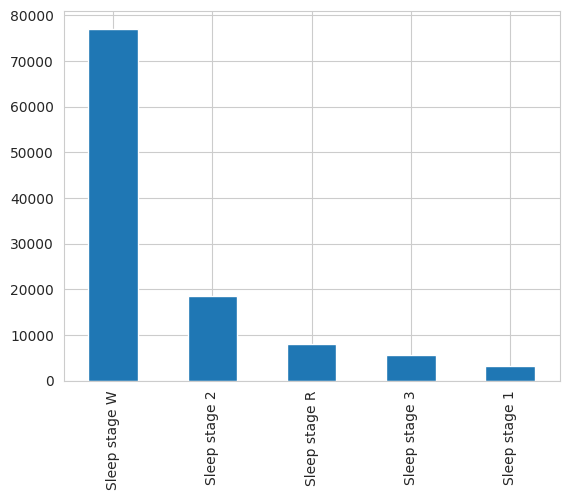

In [46]:
df_feats["label"].value_counts().plot(kind="bar")

<Axes: >

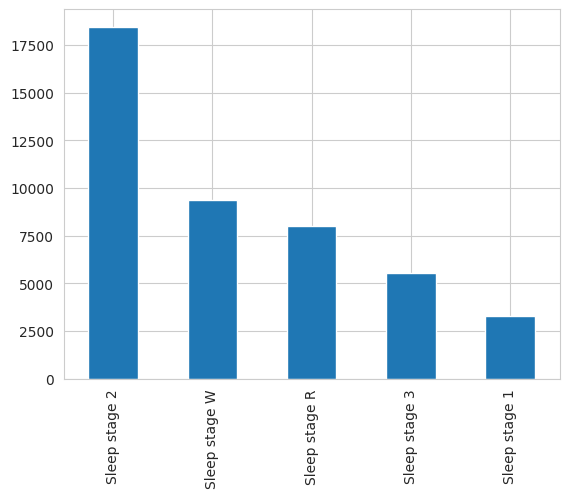

In [61]:
df_feats_trimmed_all["label"].value_counts().plot(kind="bar")

In [67]:
df_feats_trimmed_all["label"].value_counts()


Sleep stage 2    18464
Sleep stage W     9384
Sleep stage R     8025
Sleep stage 3     5550
Sleep stage 1     3286
Name: label, dtype: int64

=> There is quite some label imbalance

## EDA on features

In [48]:
skip_cols = ["edf_file", "label", "patient_id"]
feat_cols = [c for c in df_feats.columns if c not in skip_cols]

In [49]:
import math

import matplotlib.pyplot as plt

plot_cols = [c for c in feat_cols if not "_shift=" in c]

# n_cols = 10
# n_rows = math.ceil(len(plot_cols) / n_cols)
# plt.figure(figsize=(n_cols * 4.5, n_rows * 4.5))

# for idx, col in enumerate(plot_cols):
#     plt.subplot(n_rows, n_cols, idx + 1)
#     plt.boxplot(df_feats[col].dropna(), vert=True)
#     plt.xlabel(col)

# plt.tight_layout()
# plt.show()

# ML

In [50]:
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    f1_score,
    cohen_kappa_score,
    log_loss,
)
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer

from sklearn.linear_model import SGDClassifier

In [63]:
from src.visualizations import plot_linear_classification_coefs
from src.visualizations import plot_learning_curve
from src.visualizations import plot_confusion_matrix

## The simple, linear pipeline

In [78]:
### Create pipeline
pipe = Pipeline(
    [
        ("impute", SimpleImputer()),
        ("scale", QuantileTransformer(n_quantiles=100, subsample=200_000, random_state=0)),
        (
            "linear_model",
            SGDClassifier(
                loss="log_loss",
                average=True,
                class_weight="balanced",
                n_jobs=5,
                random_state=0,
            ),
        ),
    ]
)

In [70]:
### Fit the pipeline
pipe.fit(df_feats_trimmed_all[feat_cols], df_feats_trimmed_all["label"])

Pipeline(steps=[('impute', SimpleImputer()),
                ('scale',
                 QuantileTransformer(n_quantiles=100, random_state=0,
                                     subsample=200000)),
                ('linear_model',
                 SGDClassifier(average=True, class_weight='balanced',
                               loss='log_loss', n_jobs=5, random_state=0))])

In [71]:
print("Training data:")
preds = pipe.predict(df_feats_trimmed_all[feat_cols])
preds_proba = pipe.predict_proba(df_feats_trimmed_all[feat_cols])
print("Log loss:", log_loss(y_true=df_feats_trimmed_all["label"], y_pred=preds_proba))
print(classification_report(y_true=df_feats_trimmed_all["label"], y_pred=preds))

Training data:
Log loss: 0.5805277606597526
               precision    recall  f1-score   support

Sleep stage 1       0.53      0.62      0.57      3286
Sleep stage 2       0.92      0.88      0.90     18464
Sleep stage 3       0.84      0.93      0.89      5550
Sleep stage R       0.89      0.89      0.89      8025
Sleep stage W       0.94      0.91      0.93      9384

     accuracy                           0.87     44709
    macro avg       0.83      0.85      0.83     44709
 weighted avg       0.88      0.87      0.88     44709


### Grouped 5-fold results for all the data

In [79]:
# Total of 5 folds
gkfold = StratifiedGroupKFold(n_splits=5)
cv = gkfold.split(df_feats_trimmed_all, df_feats_trimmed_all["label"], groups=df_feats_trimmed_all.patient_id)

res = cross_validate(
    pipe,
    df_feats_trimmed_all[feat_cols],
    df_feats_trimmed_all["label"],
    scoring=["f1_macro", "balanced_accuracy", "accuracy", "neg_log_loss"],
    cv=cv,
    n_jobs=8,
    return_train_score=True,
    return_estimator=True,
)

In [80]:
print("5-FOLD: TRAIN")
print("  MACRO F1:          ", round(np.mean(res["train_f1_macro"]), 4))
print("  Balanced accuracy: ", round(np.mean(res["train_balanced_accuracy"]), 4))
print("  Accuracy:          ", round(np.mean(res["train_accuracy"]), 4))
print("  Log loss:          ", round(np.mean(-1 * res["train_neg_log_loss"]), 4))

10-FOLD: TRAIN
  MACRO F1:           0.8386
  Balanced accuracy:  0.8503
  Accuracy:           0.878
  Log loss:           0.6079


In [82]:
print("5-FOLD: TEST")
print("  MACRO F1:          ", round(np.mean(res["test_f1_macro"]), 4))
print("  Balanced accuracy: ", round(np.mean(res["test_balanced_accuracy"]), 4))
print("  Accuracy:          ", round(np.mean(res["test_accuracy"]), 4))
print("  Log loss:          ", round(np.mean(-1 * res["test_neg_log_loss"]), 4))

10-FOLD: TEST
  MACRO F1:           0.793
  Balanced accuracy:  0.8053
  Accuracy:           0.8442
  Log loss:           0.9348


In [84]:
preds = []
preds_proba = []
y_trues = []
cv = gkfold.split(df_feats, df_feats["label"], groups=df_feats.patient_id)
for fold_ix, (train_idx, test_idx) in enumerate(cv):
    X_train = df_feats[feat_cols].iloc[train_idx]
    y_train = df_feats["label"].iloc[train_idx]
    X_test = df_feats[feat_cols].iloc[test_idx]
    y_test = df_feats["label"].iloc[test_idx]
    
    estimator = res["estimator"][fold_ix]
    preds += [estimator.predict(X_test)]
    preds_proba += [estimator.predict_proba(X_test)]
    y_trues += [y_test]

preds = np.hstack(preds)
y_trues = np.hstack(y_trues)
preds_proba = np.vstack(preds_proba)

In [85]:
print("F1:", f1_score(preds, y_trues, average="macro"))
print("ACC:", accuracy_score(preds, y_trues))
print("KAPPA:", cohen_kappa_score(preds, y_trues))
print("LOG LOSS:", log_loss(y_trues, preds_proba))

F1: 0.8343521110487158
ACC: 0.9417174367412283
KAPPA: 0.8838309822037584
LOG LOSS: 0.30614518597268225


In [86]:
print(classification_report(preds, y_trues))

               precision    recall  f1-score   support

Sleep stage 1       0.61      0.50      0.55      4033
Sleep stage 2       0.88      0.91      0.89     17775
Sleep stage 3       0.93      0.83      0.87      6238
Sleep stage R       0.89      0.85      0.87      8454
Sleep stage W       0.98      0.99      0.99     75935

     accuracy                           0.94    112435
    macro avg       0.86      0.82      0.83    112435
 weighted avg       0.94      0.94      0.94    112435


<Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

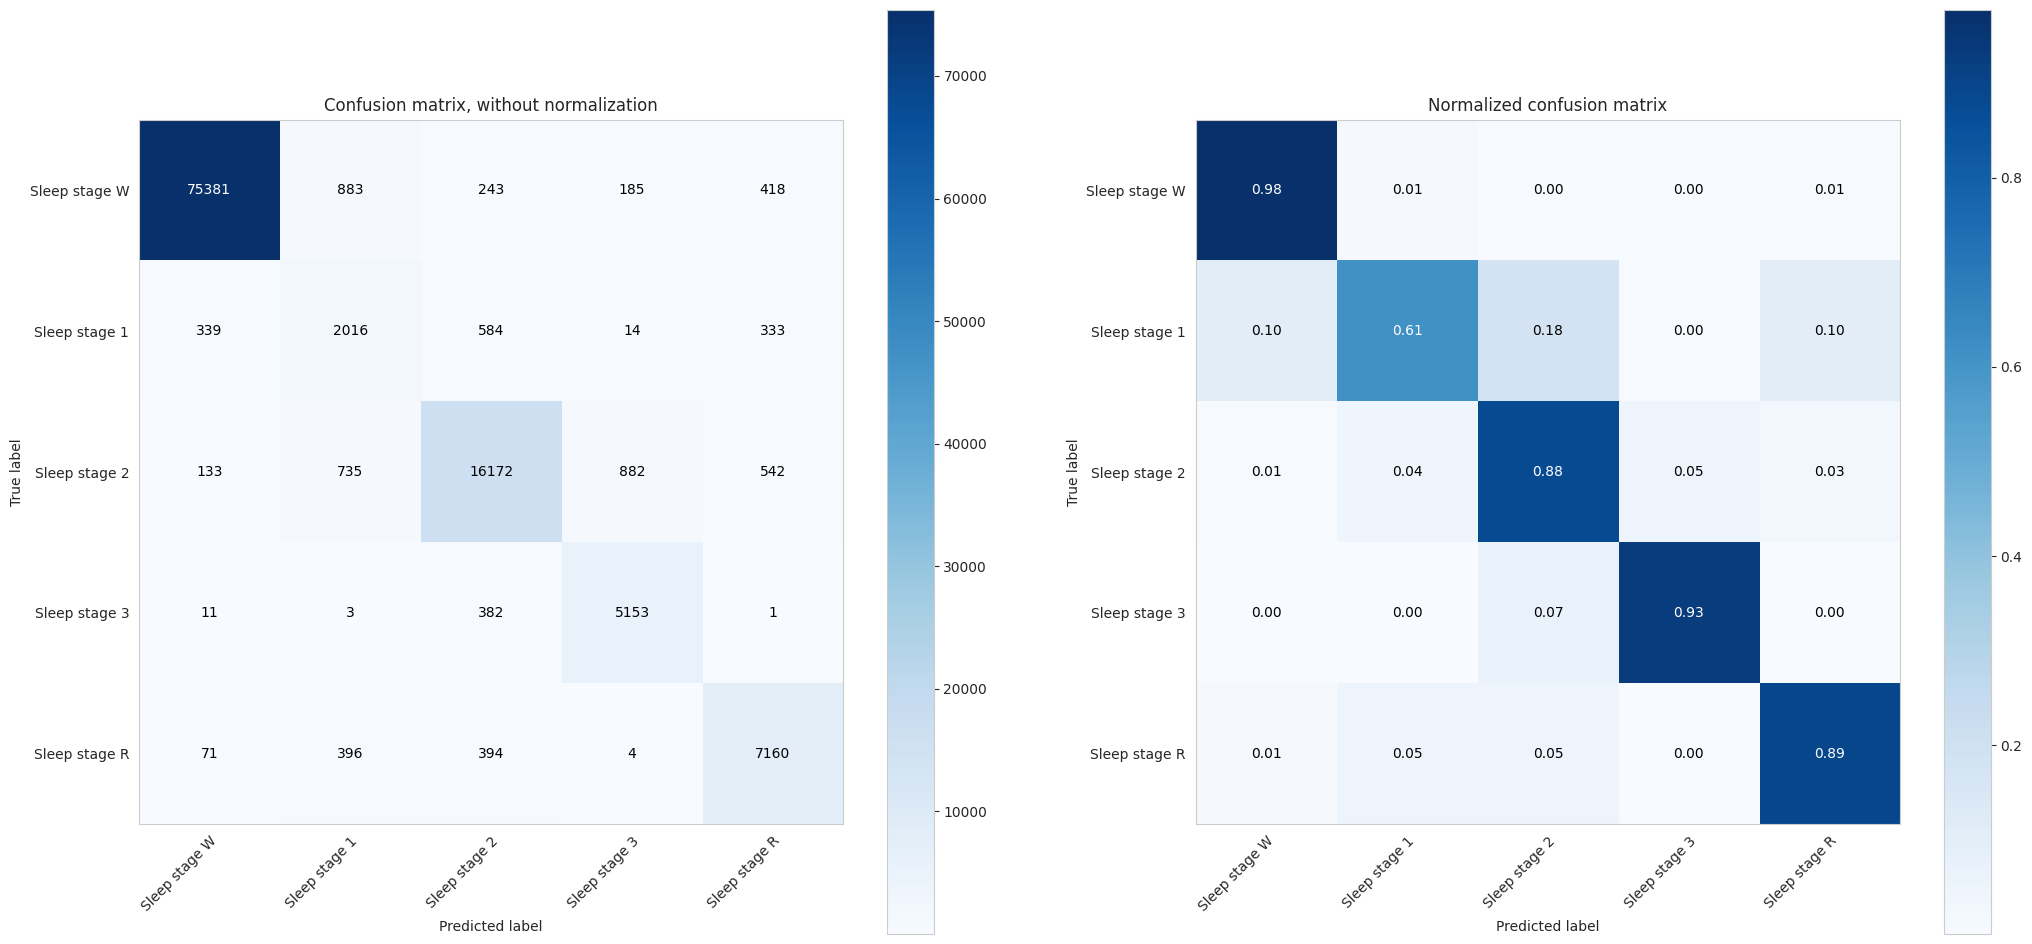

In [87]:
classes = [
    'Sleep stage W',
    'Sleep stage 1',
    'Sleep stage 2',
    'Sleep stage 3',
    'Sleep stage R'
]

plt.figure(figsize=(25,12))
ax = plt.subplot(1,2,1)
plot_confusion_matrix(y_pred=preds, y_true=y_trues, classes=classes, normalize=False, ax=ax)
ax = plt.subplot(1,2,2)
plot_confusion_matrix(y_pred=preds, y_true=y_trues, classes=classes, normalize=True, ax=ax)

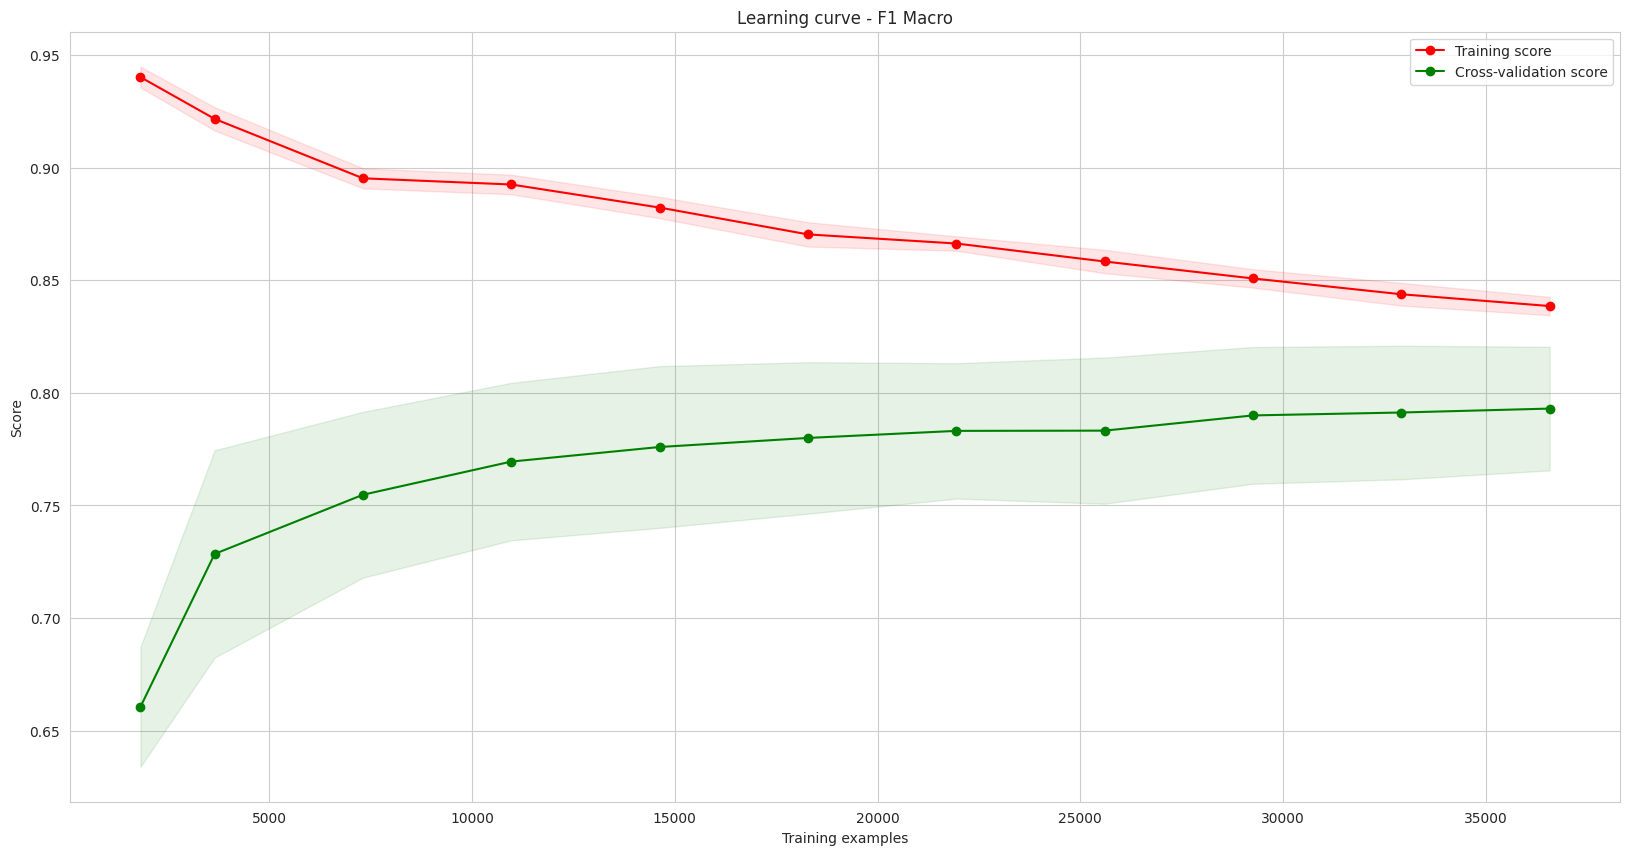

In [88]:
cv = gkfold.split(df_feats_trimmed_all, df_feats_trimmed_all["label"], groups=df_feats_trimmed_all.patient_id)

_ = plot_learning_curve(
    pipe,
    title="Learning curve - F1 Macro",
    X=df_feats_trimmed_all[feat_cols],
    y=df_feats_trimmed_all["label"],
    cv=cv,
    scoring="f1_macro",
    n_jobs=8,
    train_sizes=[0.05] + list(np.linspace(0.1,1,10))
)

## The simple, catboost pipeline

In [72]:
### Create pipeline
from catboost import CatBoostClassifier
pipe = CatBoostClassifier(verbose=0, depth=5, n_estimators=2_000, random_state=0)

In [77]:
### Fit the pipeline
pipe.fit(df_feats_trimmed_all[feat_cols], df_feats_trimmed_all["label"])
print("Training data:")
preds = pipe.predict(df_feats_trimmed_all[feat_cols])
preds_proba = pipe.predict_proba(df_feats_trimmed_all[feat_cols])
print("Log loss:", log_loss(y_true=df_feats_trimmed_all["label"], y_pred=preds_proba))
print(classification_report(y_true=df_feats_trimmed_all["label"], y_pred=preds))

Training data:
Log loss: 0.18697577247862213
               precision    recall  f1-score   support

Sleep stage 1       0.88      0.71      0.78      3286
Sleep stage 2       0.93      0.96      0.94     18464
Sleep stage 3       0.93      0.93      0.93      5550
Sleep stage R       0.93      0.95      0.94      8025
Sleep stage W       0.97      0.97      0.97      9384

     accuracy                           0.94     44709
    macro avg       0.93      0.90      0.91     44709
 weighted avg       0.94      0.94      0.94     44709


### Grouped 22-fold for all the data

In [74]:
df_feats.patient_id.nunique()

23

In [76]:
# Total of 10 folds
gkfold = GroupKFold(n_splits=22)
cv = gkfold.split(df_feats_trimmed_all, groups=df_feats_trimmed_all.patient_id)

res = cross_validate(
    pipe,
    df_feats_trimmed_all[feat_cols],
    df_feats_trimmed_all["label"],
    scoring=["f1_macro", "balanced_accuracy", "accuracy", "neg_log_loss"],
    cv=cv,
    # n_jobs=30,
    return_train_score=True,
    return_estimator=True,
)

KeyboardInterrupt: 

In [75]:
print("22-FOLD: TRAIN")
print("  MACRO F1:          ", round(np.mean(res["train_f1_macro"]), 4))
print("  Balanced accuracy: ", round(np.mean(res["train_balanced_accuracy"]), 4))
print("  Accuracy:          ", round(np.mean(res["train_accuracy"]), 4))
print("  Log loss:          ", round(np.mean(-1 * res["train_neg_log_loss"]), 4))

22-FOLD: TRAIN
  MACRO F1:           0.9355
  Balanced accuracy:  0.927
  Accuracy:           0.9462
  Log loss:           0.1699


In [76]:
print("22-FOLD: TEST")
print("  MACRO F1:          ", round(np.mean(res["test_f1_macro"]), 4))
print("  Balanced accuracy: ", round(np.mean(res["test_balanced_accuracy"]), 4))
print("  Accuracy:          ", round(np.mean(res["test_accuracy"]), 4))
print("  Log loss:          ", round(np.mean(-1 * res["test_neg_log_loss"]), 4))

22-FOLD: TEST
  MACRO F1:           0.779
  Balanced accuracy:  0.7898
  Accuracy:           0.8365
  Log loss:           0.4348


In [79]:
preds = []
preds_proba = []
y_trues = []
cv = gkfold.split(df_feats, df_feats["label"], groups=df_feats.patient_id)
for fold_ix, (train_idx, test_idx) in enumerate(cv):
    X_train = df_feats[feat_cols].iloc[train_idx]
    y_train = df_feats["label"].iloc[train_idx]
    X_test = df_feats[feat_cols].iloc[test_idx]
    y_test = df_feats["label"].iloc[test_idx]
    
    estimator = res["estimator"][fold_ix]
    preds += [estimator.predict(X_test).ravel()]
    preds_proba += [estimator.predict_proba(X_test)]
    y_trues += [y_test]

preds = np.hstack(preds)
y_trues = np.hstack(y_trues)
preds_proba = np.vstack(preds_proba)

In [80]:
print("F1:", f1_score(preds, y_trues, average="macro"))
print("ACC:", accuracy_score(preds, y_trues))
print("KAPPA:", cohen_kappa_score(preds, y_trues))
print("LOG LOSS:", log_loss(y_trues, preds_proba))

F1: 0.795091260707293
ACC: 0.8362802881466929
KAPPA: 0.7650660701989241
LOG LOSS: 0.4361518421826315


In [81]:
print(classification_report(preds, y_trues))

               precision    recall  f1-score   support

Sleep stage 1       0.52      0.63      0.57      3019
Sleep stage 2       0.89      0.85      0.87     20945
Sleep stage 3       0.77      0.81      0.79      6091
Sleep stage R       0.86      0.89      0.88      8094
Sleep stage W       0.88      0.85      0.86      4607

     accuracy                           0.84     42756
    macro avg       0.79      0.81      0.80     42756
 weighted avg       0.84      0.84      0.84     42756


<AxesSubplot:title={'center':'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

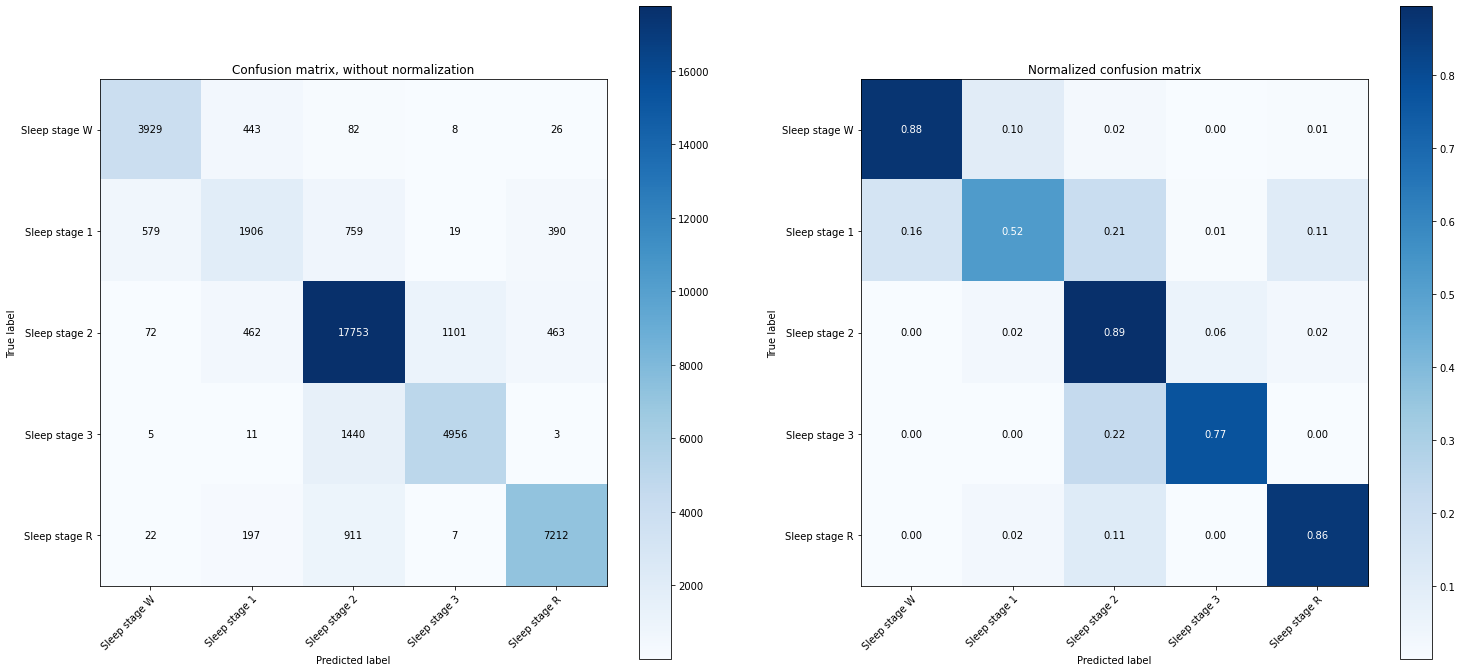

In [82]:
classes = [
    'Sleep stage W',
    'Sleep stage 1',
    'Sleep stage 2',
    'Sleep stage 3',
    'Sleep stage R'
]

plt.figure(figsize=(25,12))
ax = plt.subplot(1,2,1)
plot_confusion_matrix(y_pred=preds, y_true=y_trues, classes=classes, normalize=False, ax=ax)
ax = plt.subplot(1,2,2)
plot_confusion_matrix(y_pred=preds, y_true=y_trues, classes=classes, normalize=True, ax=ax)